# Credit-Greedy Strategy Analysis

This notebook analyzes the credit-greedy scheduling strategy's behavior across different carbon intensity levels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [2]:
# Load timeseries data
df = pd.read_csv('results/simple_20251118_155722/credit-greedy/timeseries.csv')

# Calculate percentages
df['total_requests'] = df['requests_precision_30'] + df['requests_precision_50'] + df['requests_precision_100']
df['p30_pct'] = (df['requests_precision_30'] / df['total_requests']) * 100
df['p50_pct'] = (df['requests_precision_50'] / df['total_requests']) * 100
df['p100_pct'] = (df['requests_precision_100'] / df['total_requests']) * 100

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Total samples: {len(df)}")
print(f"Duration: {df['elapsed_seconds'].max():.1f} seconds")
print(f"Total requests: {df['total_requests'].sum():.0f}")
df.head()

Total samples: 119
Duration: 602.5 seconds
Total requests: 328050


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,...,replicas_consumer,replicas_target,ceiling_router,ceiling_consumer,ceiling_target,throttle_factor,total_requests,p30_pct,p50_pct,p100_pct
0,2025-11-18 15:58:50.441561+00:00,5.0,2000,0.8235,1.0000,0.1590,0.8170,70.0,80.0,323,...,0,0,NaN,NaN,NaN,0.0,2000,16.150000,12.700000,71.150000
1,2025-11-18 15:58:55.499492+00:00,10.1,2571,0.8272,1.0000,0.1537,0.8167,80.0,120.0,391,...,0,0,NaN,NaN,NaN,0.0,2571,15.208090,13.263322,71.528588
2,2025-11-18 15:59:00.566647+00:00,15.1,2366,0.8249,1.0000,0.1463,0.8167,80.0,120.0,376,...,0,0,NaN,NaN,NaN,0.0,2366,15.891801,12.764159,71.344041
3,2025-11-18 15:59:05.641210+00:00,20.2,2614,0.8244,1.0000,0.1372,0.8167,80.0,120.0,418,...,0,0,NaN,NaN,NaN,0.0,2614,15.990819,12.739097,71.270084
4,2025-11-18 15:59:10.691849+00:00,25.3,2484,0.7416,0.9089,0.1091,0.6089,120.0,160.0,609,...,0,0,NaN,NaN,NaN,0.0,2484,24.516908,17.351047,58.132045


## 2. Carbon Intensity Distribution

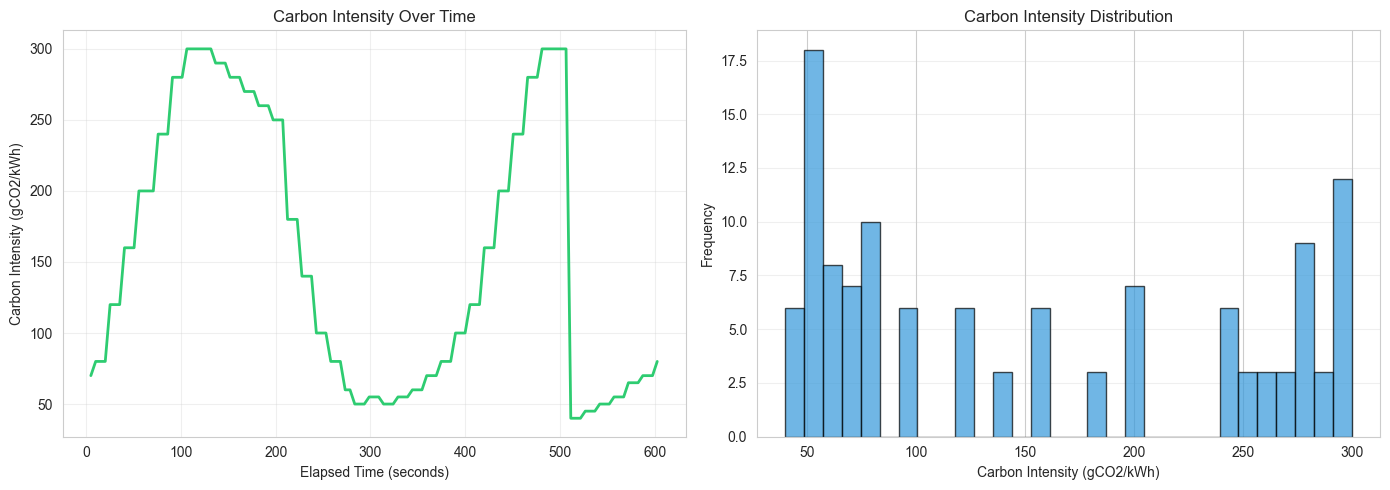

Carbon intensity range: 40 - 300 gCO2/kWh
Mean carbon intensity: 154.6 gCO2/kWh


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of carbon intensity
axes[0].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2, color='#2ecc71')
axes[0].set_xlabel('Elapsed Time (seconds)')
axes[0].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[0].set_title('Carbon Intensity Over Time')
axes[0].grid(True, alpha=0.3)

# Distribution histogram
axes[1].hist(df['carbon_now'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Carbon Intensity Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Carbon intensity range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"Mean carbon intensity: {df['carbon_now'].mean():.1f} gCO2/kWh")

## 3. Precision Distribution Over Time

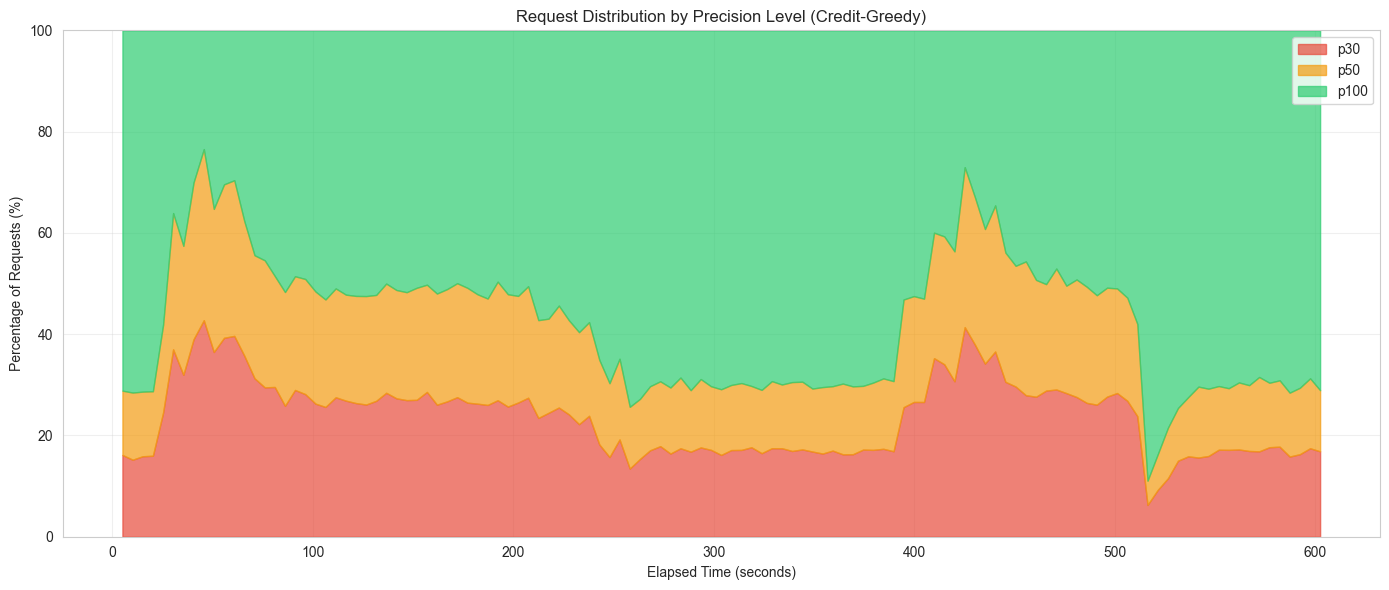

Overall precision distribution:
  p30: 23.5%
  p50: 18.6%
  p100: 57.9%


In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

# Stacked area chart
ax.fill_between(df['elapsed_seconds'], 0, df['p30_pct'], label='p30', alpha=0.7, color='#e74c3c')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'], df['p30_pct'] + df['p50_pct'], label='p50', alpha=0.7, color='#f39c12')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'] + df['p50_pct'], 100, label='p100', alpha=0.7, color='#2ecc71')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Percentage of Requests (%)')
ax.set_title('Request Distribution by Precision Level (Credit-Greedy)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("Overall precision distribution:")
print(f"  p30: {df['p30_pct'].mean():.1f}%")
print(f"  p50: {df['p50_pct'].mean():.1f}%")
print(f"  p100: {df['p100_pct'].mean():.1f}%")

## 4. Carbon-Aware Behavior Analysis

### Key Question: Does p100 usage vary significantly between low and high carbon periods?

In [5]:
# Define carbon level categories
very_low = df[df['carbon_now'] <= 60]
low = df[df['carbon_now'] <= 80]
mid = df[(df['carbon_now'] > 80) & (df['carbon_now'] < 240)]
high = df[df['carbon_now'] >= 240]
very_high = df[df['carbon_now'] >= 280]

print("=" * 80)
print("CARBON-AWARE BEHAVIOR ANALYSIS")
print("=" * 80)
print()
print(f"VERY LOW (≤60 gCO2/kWh):  {len(very_low):3d} samples  |  p100: {very_low['p100_pct'].mean():5.1f}%  |  Weight: {very_low['commanded_weight_100'].mean():.1f}%")
print(f"LOW (≤80 gCO2/kWh):       {len(low):3d} samples  |  p100: {low['p100_pct'].mean():5.1f}%  |  Weight: {low['commanded_weight_100'].mean():.1f}%")
print(f"MID (80-240 gCO2/kWh):    {len(mid):3d} samples  |  p100: {mid['p100_pct'].mean():5.1f}%  |  Weight: {mid['commanded_weight_100'].mean():.1f}%")
print(f"HIGH (≥240 gCO2/kWh):     {len(high):3d} samples  |  p100: {high['p100_pct'].mean():5.1f}%  |  Weight: {high['commanded_weight_100'].mean():.1f}%")
print(f"VERY HIGH (≥280 gCO2/kWh): {len(very_high):3d} samples  |  p100: {very_high['p100_pct'].mean():5.1f}%  |  Weight: {very_high['commanded_weight_100'].mean():.1f}%")
print()
print(f"P100 SWING (Low - High): {low['p100_pct'].mean() - high['p100_pct'].mean():+.1f} percentage points")
print(f"P100 SWING (Very Low - Very High): {very_low['p100_pct'].mean() - very_high['p100_pct'].mean():+.1f} percentage points")
print()

swing = low['p100_pct'].mean() - high['p100_pct'].mean()
if swing >= 20:
    print("✅ EXCELLENT: Significant variation (≥20 points) - Highly carbon-aware!")
elif swing >= 10:
    print("✓ GOOD: Moderate variation (10-20 points) - Carbon-aware behavior detected")
elif swing >= 5:
    print("⚠️ FAIR: Small variation (5-10 points) - Weakly carbon-aware")
elif swing > 0:
    print("⚠️ POOR: Minimal variation (<5 points) - Barely carbon-aware")
else:
    print("❌ BAD: Negative or no variation - System not responding correctly to carbon intensity")

CARBON-AWARE BEHAVIOR ANALYSIS

VERY LOW (≤60 gCO2/kWh):   29 samples  |  p100:  71.3%  |  Weight: 71.8%
LOW (≤80 gCO2/kWh):        49 samples  |  p100:  71.0%  |  Weight: 71.2%
MID (80-240 gCO2/kWh):     31 samples  |  p100:  46.4%  |  Weight: 45.5%
HIGH (≥240 gCO2/kWh):      39 samples  |  p100:  50.6%  |  Weight: 50.5%
VERY HIGH (≥280 gCO2/kWh):  24 samples  |  p100:  51.0%  |  Weight: 50.7%

P100 SWING (Low - High): +20.4 percentage points
P100 SWING (Very Low - Very High): +20.3 percentage points

✅ EXCELLENT: Significant variation (≥20 points) - Highly carbon-aware!


### Visualization: p100 Usage vs Carbon Intensity

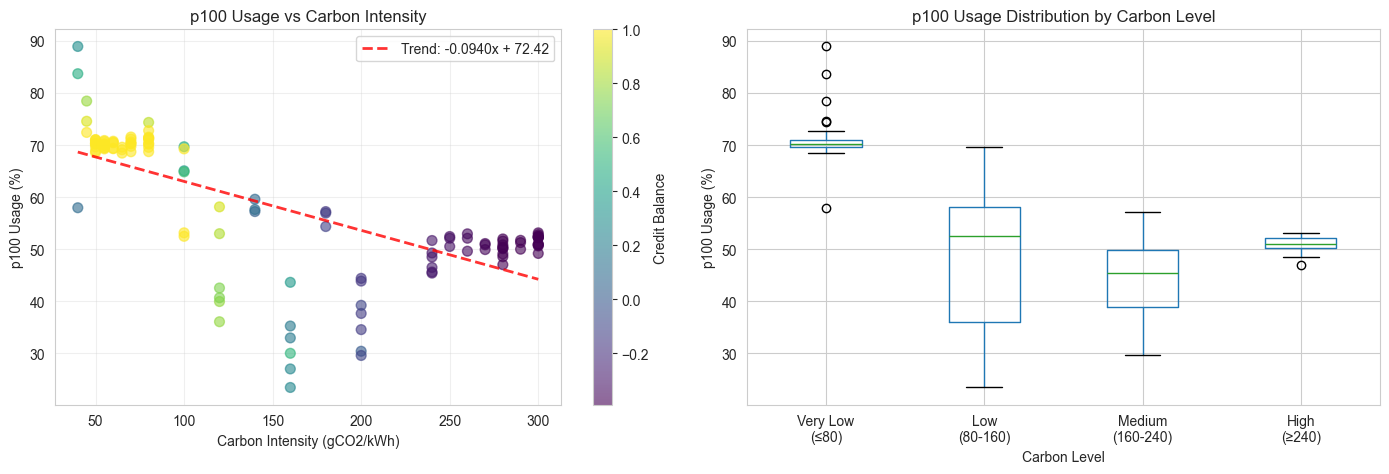

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
scatter = axes[0].scatter(df['carbon_now'], df['p100_pct'], c=df['credit_balance'], 
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('Carbon Intensity (gCO2/kWh)')
axes[0].set_ylabel('p100 Usage (%)')
axes[0].set_title('p100 Usage vs Carbon Intensity')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Credit Balance')

# Trend line
z = np.polyfit(df['carbon_now'], df['p100_pct'], 1)
p = np.poly1d(z)
axes[0].plot(df['carbon_now'].sort_values(), p(df['carbon_now'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')
axes[0].legend()

# Box plot by carbon category
carbon_categories = pd.cut(df['carbon_now'], bins=[0, 80, 160, 240, 400], 
                           labels=['Very Low\n(≤80)', 'Low\n(80-160)', 'Medium\n(160-240)', 'High\n(≥240)'])
df_plot = df.copy()
df_plot['carbon_category'] = carbon_categories
df_plot.boxplot(column='p100_pct', by='carbon_category', ax=axes[1])
axes[1].set_xlabel('Carbon Level')
axes[1].set_ylabel('p100 Usage (%)')
axes[1].set_title('p100 Usage Distribution by Carbon Level')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

## 5. Credit Balance Dynamics

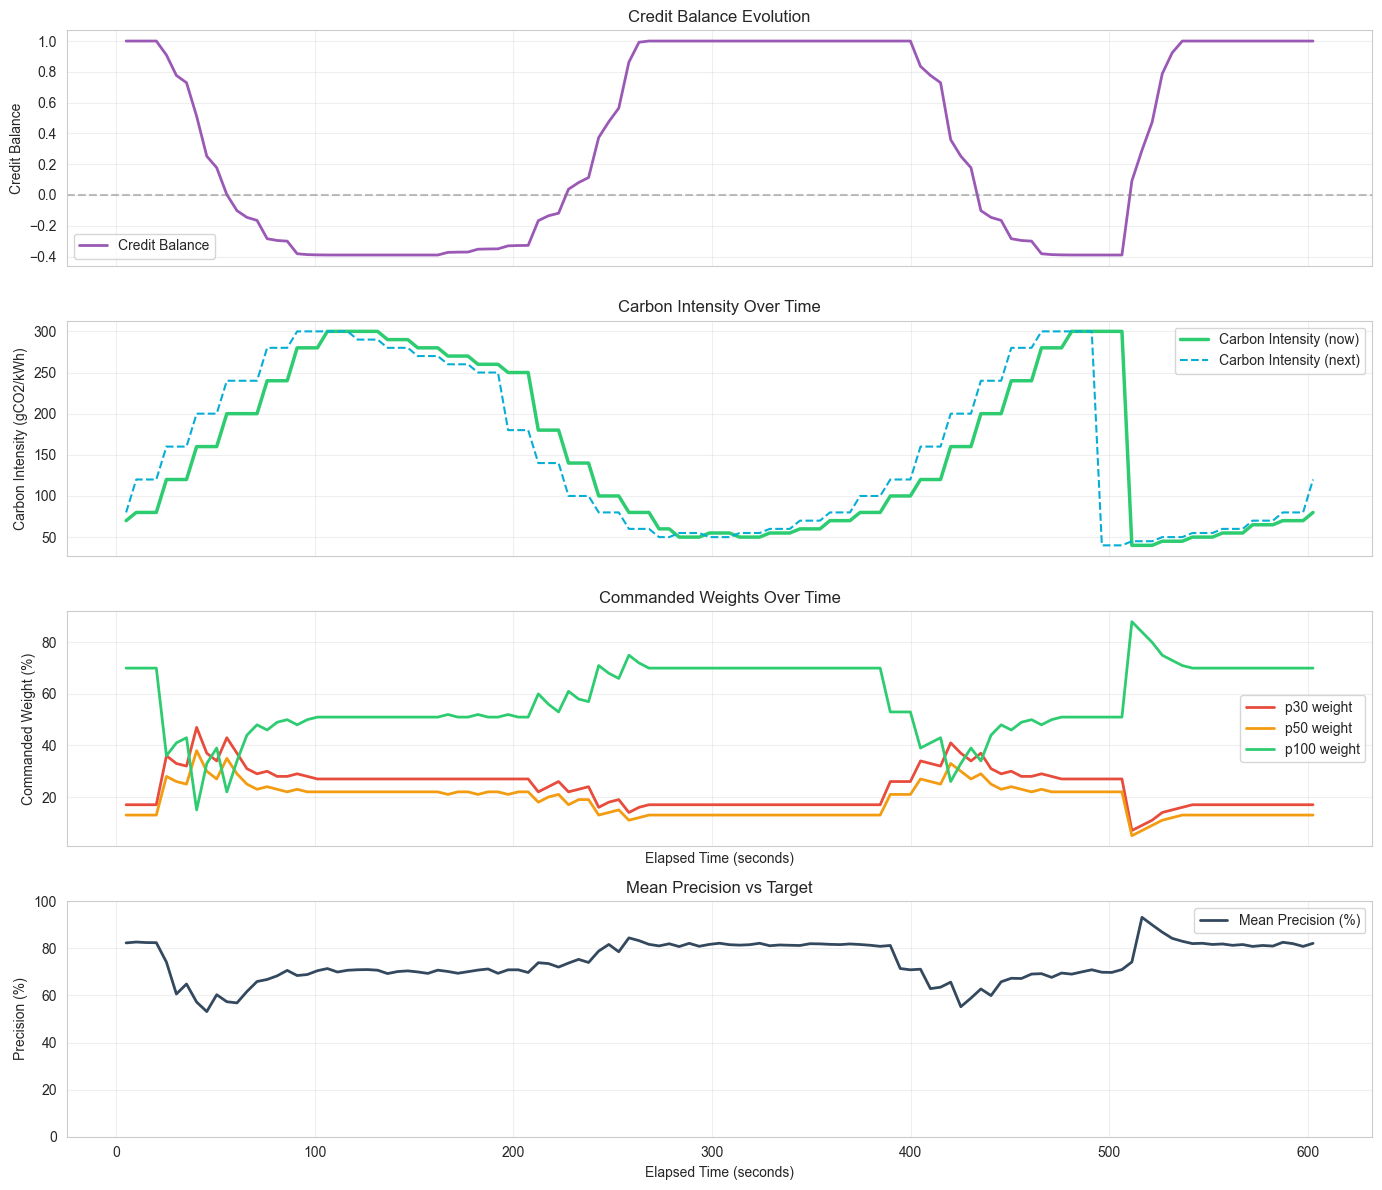

Credit balance range: -0.3901 to 1.0000
Mean credit balance: 0.3534


In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1) Credit balance over time
axes[0].plot(df['elapsed_seconds'], df['credit_balance'], linewidth=2, color='#9b59b6', label='Credit Balance')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Credit Balance')
axes[0].set_title('Credit Balance Evolution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Carbon intensity main chart (new)
axes[1].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2.5, color='#2ecc71', label='Carbon Intensity (now)')
if 'carbon_next' in df.columns:
    axes[1].plot(df['elapsed_seconds'], df['carbon_next'], linewidth=1.5, color='#06AED5', linestyle='--', label='Carbon Intensity (next)')
axes[1].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_title('Carbon Intensity Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3) Commanded weights over time
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_30'], linewidth=2, label='p30 weight', color='#e74c3c')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_50'], linewidth=2, label='p50 weight', color='#f39c12')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_100'], linewidth=2, label='p100 weight', color='#2ecc71')
axes[2].set_xlabel('Elapsed Time (seconds)')
axes[2].set_ylabel('Commanded Weight (%)')
axes[2].set_title('Commanded Weights Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4) Target quality / mean precision over time
# Use 'mean_precision' as actual quality and try to derive target precision from target_error or credit_target if available
if 'mean_precision' in df.columns:
    actual_precision = df['mean_precision']
else:
    # fallback: estimate mean precision from commanded weights and precision tiers
    # Assume p100 -> 1.0, p50 -> 0.5, p30 -> 0.3 to create a proxy
    actual_precision = (df['requests_precision_100'].astype(float) * 1.0 +
                        df['requests_precision_50'].astype(float) * 0.5 +
                        df['requests_precision_30'].astype(float) * 0.3) / df['total_requests']

# Compute a constant target precision if target columns exist
# Decision engine writes target error to 'target_error' or 'credit_target' may exist

target_precision = None
if 'target_error' in df.columns:
    try:
        target_precision = 1.0 - df['target_error'].astype(float)
    except Exception:
        target_precision = None
elif 'credit_target' in df.columns:
    try:
        target_precision = 1.0 - df['credit_target'].astype(float)
    except Exception:
        target_precision = None

# Plot actual mean precision
axes[3].plot(df['elapsed_seconds'], actual_precision * 100, linewidth=2, color='#34495e', label='Mean Precision (%)')

# Plot target precision if available
if target_precision is not None:
    # If target_precision is a series, convert to percent; otherwise plot a constant line
    try:
        unique_vals = sorted(pd.Series(target_precision).unique())
    except Exception:
        unique_vals = []

    if len(unique_vals) == 1:
        axes[3].axhline(y=float(unique_vals[0]) * 100, color='red', linestyle='--', linewidth=2,
                        label=f'Target Precision ({float(unique_vals[0])*100:.0f}%)')
    else:
        axes[3].plot(df['elapsed_seconds'], target_precision * 100, color='red', linestyle='--', linewidth=2, label='Target Precision (%)')

axes[3].set_xlabel('Elapsed Time (seconds)')
axes[3].set_ylabel('Precision (%)')
axes[3].set_title('Mean Precision vs Target')
axes[3].set_ylim(0, 100)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Credit balance range: {df['credit_balance'].min():.4f} to {df['credit_balance'].max():.4f}")
print(f"Mean credit balance: {df['credit_balance'].mean():.4f}")

## 6. Commanded vs Actual Traffic Distribution

Commanded Weight vs Actual Traffic Distribution:
                      p100_pct  p50_pct  p30_pct  carbon_now  samples
commanded_weight_100                                                 
15                        30.0     31.0     39.0       160.0        1
22                        30.4     30.3     39.3       200.0        1
26                        43.6     25.7     30.7       160.0        1
33                        25.2     32.7     42.1       160.0        2
34                        34.4     28.7     36.9       200.0        2
36                        58.1     17.4     24.5       120.0        1
39                        40.4     25.9     33.7       146.7        3
41                        38.0     25.8     36.1       120.0        2
43                        41.6     25.4     33.0       120.0        2
44                        36.1     27.7     36.2       200.0        2
46                        46.0     24.5     29.6       240.0        2
48                        46.7     23.3  

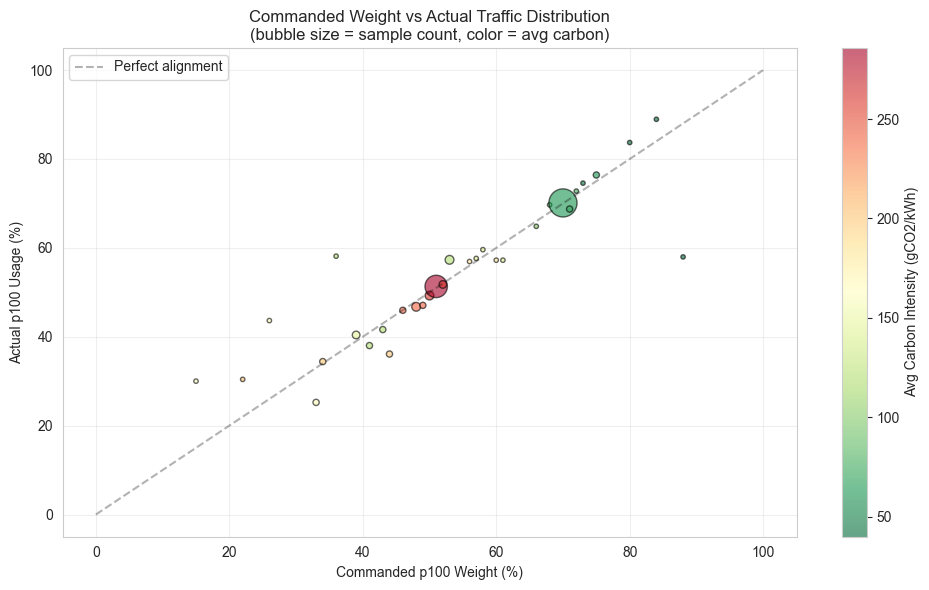

In [8]:
# Group by commanded weight to see if actual distribution matches
weight_groups = df.groupby('commanded_weight_100').agg({
    'p100_pct': 'mean',
    'p50_pct': 'mean',
    'p30_pct': 'mean',
    'carbon_now': 'mean',
    'elapsed_seconds': 'count'
}).rename(columns={'elapsed_seconds': 'samples'})

print("Commanded Weight vs Actual Traffic Distribution:")
print("=" * 80)
print(weight_groups.round(1))
print()

fig, ax = plt.subplots(figsize=(10, 6))
x = weight_groups.index
ax.scatter(x, weight_groups['p100_pct'], s=weight_groups['samples']*10, 
           c=weight_groups['carbon_now'], cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect alignment')
ax.set_xlabel('Commanded p100 Weight (%)')
ax.set_ylabel('Actual p100 Usage (%)')
ax.set_title('Commanded Weight vs Actual Traffic Distribution\n(bubble size = sample count, color = avg carbon)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(ax.collections[0], label='Avg Carbon Intensity (gCO2/kWh)')
plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [9]:
print("=" * 80)
print("CREDIT-GREEDY STRATEGY SUMMARY")
print("=" * 80)
print()
print(f"Test Duration: {df['elapsed_seconds'].max():.1f} seconds ({df['elapsed_seconds'].max()/60:.1f} minutes)")
print(f"Total Requests: {df['total_requests'].sum():.0f}")
print(f"Avg Throughput: {df['delta_requests'].mean():.1f} req/sample")
print()
print("Precision Distribution:")
print(f"  p30: {df['p30_pct'].mean():5.1f}% (range: {df['p30_pct'].min():.1f}% - {df['p30_pct'].max():.1f}%)")
print(f"  p50: {df['p50_pct'].mean():5.1f}% (range: {df['p50_pct'].min():.1f}% - {df['p50_pct'].max():.1f}%)")
print(f"  p100: {df['p100_pct'].mean():5.1f}% (range: {df['p100_pct'].min():.1f}% - {df['p100_pct'].max():.1f}%)")
print()
print("Carbon Intensity:")
print(f"  Range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"  Mean: {df['carbon_now'].mean():.1f} gCO2/kWh")
print()
print("Credit Balance:")
print(f"  Range: {df['credit_balance'].min():.4f} to {df['credit_balance'].max():.4f}")
print(f"  Mean: {df['credit_balance'].mean():.4f}")
print()
print("Carbon-Aware Behavior:")
swing = low['p100_pct'].mean() - high['p100_pct'].mean()
print(f"  p100 swing (Low - High carbon): {swing:+.1f} percentage points")
if swing >= 10:
    print("  ✓ System shows carbon-aware behavior")
else:
    print("  ⚠️ System shows weak carbon-aware behavior (<10 point swing)")

CREDIT-GREEDY STRATEGY SUMMARY

Test Duration: 602.5 seconds (10.0 minutes)
Total Requests: 328050
Avg Throughput: 2756.7 req/sample

Precision Distribution:
  p30:  23.5% (range: 6.3% - 42.8%)
  p50:  18.6% (range: 4.8% - 33.8%)
  p100:  57.9% (range: 23.4% - 88.9%)

Carbon Intensity:
  Range: 40 - 300 gCO2/kWh
  Mean: 154.6 gCO2/kWh

Credit Balance:
  Range: -0.3901 to 1.0000
  Mean: 0.3534

Carbon-Aware Behavior:
  p100 swing (Low - High carbon): +20.4 percentage points
  ✓ System shows carbon-aware behavior
